# Modeling and Evaluation

## Agenda
1. Importing libraries  
2. Data Loading  
3. Data Exploration and Understanding <br>
    3.1. Dataset Description <br>
    3.2. Fraud Analysis<br>
    3.3. Temporal Pattern Analysis<br>
    3.4. Transaction Amounts Analysis<br>
    3.5. Feature Correlation Analysis
5. EDA Summary and Key Insights

# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import psycopg2
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
import math
import warnings
warnings.filterwarnings('ignore')

# plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)


# Data Loading

In [2]:
# connection
conn = psycopg2.connect(
    dbname='fraud-detection',
    user='airflow',
    password='airflow',
    host='localhost',
    port='5432'
)

# reading transaction table
df = pd.read_sql("SELECT * FROM transactions", conn)

# close connection
conn.close()


#display df
display(df)

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO
0,0,2018-04-01 00:00:31,596,3156,57.16,31,0,0,0
1,1,2018-04-01 00:02:10,4961,3412,81.51,130,0,0,0
2,2,2018-04-01 00:07:56,2,1365,146.00,476,0,0,0
3,3,2018-04-01 00:09:29,4128,8737,64.49,569,0,0,0
4,4,2018-04-01 00:10:34,927,9906,50.99,634,0,0,0
...,...,...,...,...,...,...,...,...,...
1754150,1754150,2018-09-30 23:56:36,161,655,54.24,15810996,182,0,0
1754151,1754151,2018-09-30 23:57:38,4342,6181,1.23,15811058,182,0,0
1754152,1754152,2018-09-30 23:58:21,618,1502,6.62,15811101,182,0,0
1754153,1754153,2018-09-30 23:59:52,4056,3067,55.40,15811192,182,0,0


# Data Exploration and Understanding

## 3.1. Dataset Description
1.	**TRANSACTION_ID**: A unique identifier for each transaction in the dataset.
2.	**TX_DATETIME**: The date and time when the transaction occurred. This column helps in analyzing the temporal aspects of transactions, such as trends over time.
3.	**CUSTOMER_ID**: A unique identifier for the customer involved in the transaction. This column is crucial for understanding customer behavior and identifying patterns that may indicate fraudulent activity.
4.	**TERMINAL_ID**: A unique identifier for the terminal where the transaction was processed. Monitoring terminal usage can help detect patterns that may suggest terminal compromise or misuse.
5.	**TX_AMOUNT**: The amount of money involved in the transaction. This column is key for identifying suspiciously large transactions or unusual spending patterns.
6.	**TX_TIME_SECONDS**: The time of the transaction in seconds from the start of the day. This provides a more granular view of the transaction time, which can be useful for detecting unusual transaction timings.
7.	**TX_TIME_DAYS**: The number of days from a reference point, indicating the transaction's occurrence day. This can help in trend analysis and detecting long-term patterns.
8.	**TX_FRAUD**: A binary indicator (0 or 1) indicating whether the transaction was identified as fraudulent. This is the target variable for the fraud detection model.
9.	**TX_FRAUD_SCENARIO**: A code indicating the type or scenario of fraud, if applicable. The unique values in this column are:
    - 0: No fraud
    - 1 (Scenario 1): Transactions with an amount greater than 220 are marked as fraudulent. This scenario provides a straightforward fraud pattern for validation purposes.
    - 2 (Scenario 2): Two terminals are randomly selected each day, and all transactions on these terminals in the next 28 days are marked as fraudulent. This simulates criminal activity involving compromised terminals.
    - 3 (Scenario 3): Three customers are randomly selected each day, and in the next 14 days, one-third of their transactions have their amounts multiplied by 5 and are marked as fraudulent. This represents a card-not-present fraud scenario, where a fraudster uses leaked customer credentials.


In [3]:

# basic info
print("\n1. Dataset Overview:")
print(f"   - Total transactions: {len(df):,}")
print(f"   - Date range: {df['TX_DATETIME'].min()} to {df['TX_DATETIME'].max()}")
print(f"   - Unique customers: {df['CUSTOMER_ID'].nunique():,}")
print(f"   - Unique terminals: {df['TERMINAL_ID'].nunique():,}")


# data types 
print("\n2. Data Quality Check:")
print("\nData Types:")
print(df.dtypes)

#missing values
print("\nMissing Values:")
missing_data = df.isnull().sum()
print(missing_data[missing_data > 0] if missing_data.sum() > 0 else "No missing values found")

#duplicates
print("\nDuplicate Records:")
duplicates = df.duplicated().sum()
print(f"Total duplicates: {duplicates}")


1. Dataset Overview:
   - Total transactions: 1,754,155
   - Date range: 2018-04-01 00:00:31 to 2018-09-30 23:59:57
   - Unique customers: 4,990
   - Unique terminals: 10,000

2. Data Quality Check:

Data Types:
TRANSACTION_ID                int64
TX_DATETIME          datetime64[ns]
CUSTOMER_ID                   int64
TERMINAL_ID                   int64
TX_AMOUNT                   float64
TX_TIME_SECONDS               int64
TX_TIME_DAYS                  int64
TX_FRAUD                      int64
TX_FRAUD_SCENARIO             int64
dtype: object

Missing Values:
No missing values found

Duplicate Records:
Total duplicates: 0


### Remarks

- Perfect data quality: no missing values, no duplicates
- Clean temporal data: 6-month continuous period
- Balanced terminal/customer distribution
- Data ready for analysis and modeling

## 3.2. Fruad Analysis


1. Overall Fraud Statistics:
   - Total transactions: 1,754,155
   - Total legitimate transactions: 1,739,474
   - Overall non-fraud rate: 99.163%
   - Total fraudulent transactions: 14,681
   - Overall fraud rate: 0.837%

2. Fraud by Scenario:
   - Scenario 0 (No fraud): 1,739,474 (99.163%)
   - Scenario 1 (Fraud type 1): 973 (0.055%)
   - Scenario 2 (Fraud type 2): 9,077 (0.517%)
   - Scenario 3 (Fraud type 3): 4,631 (0.264%)


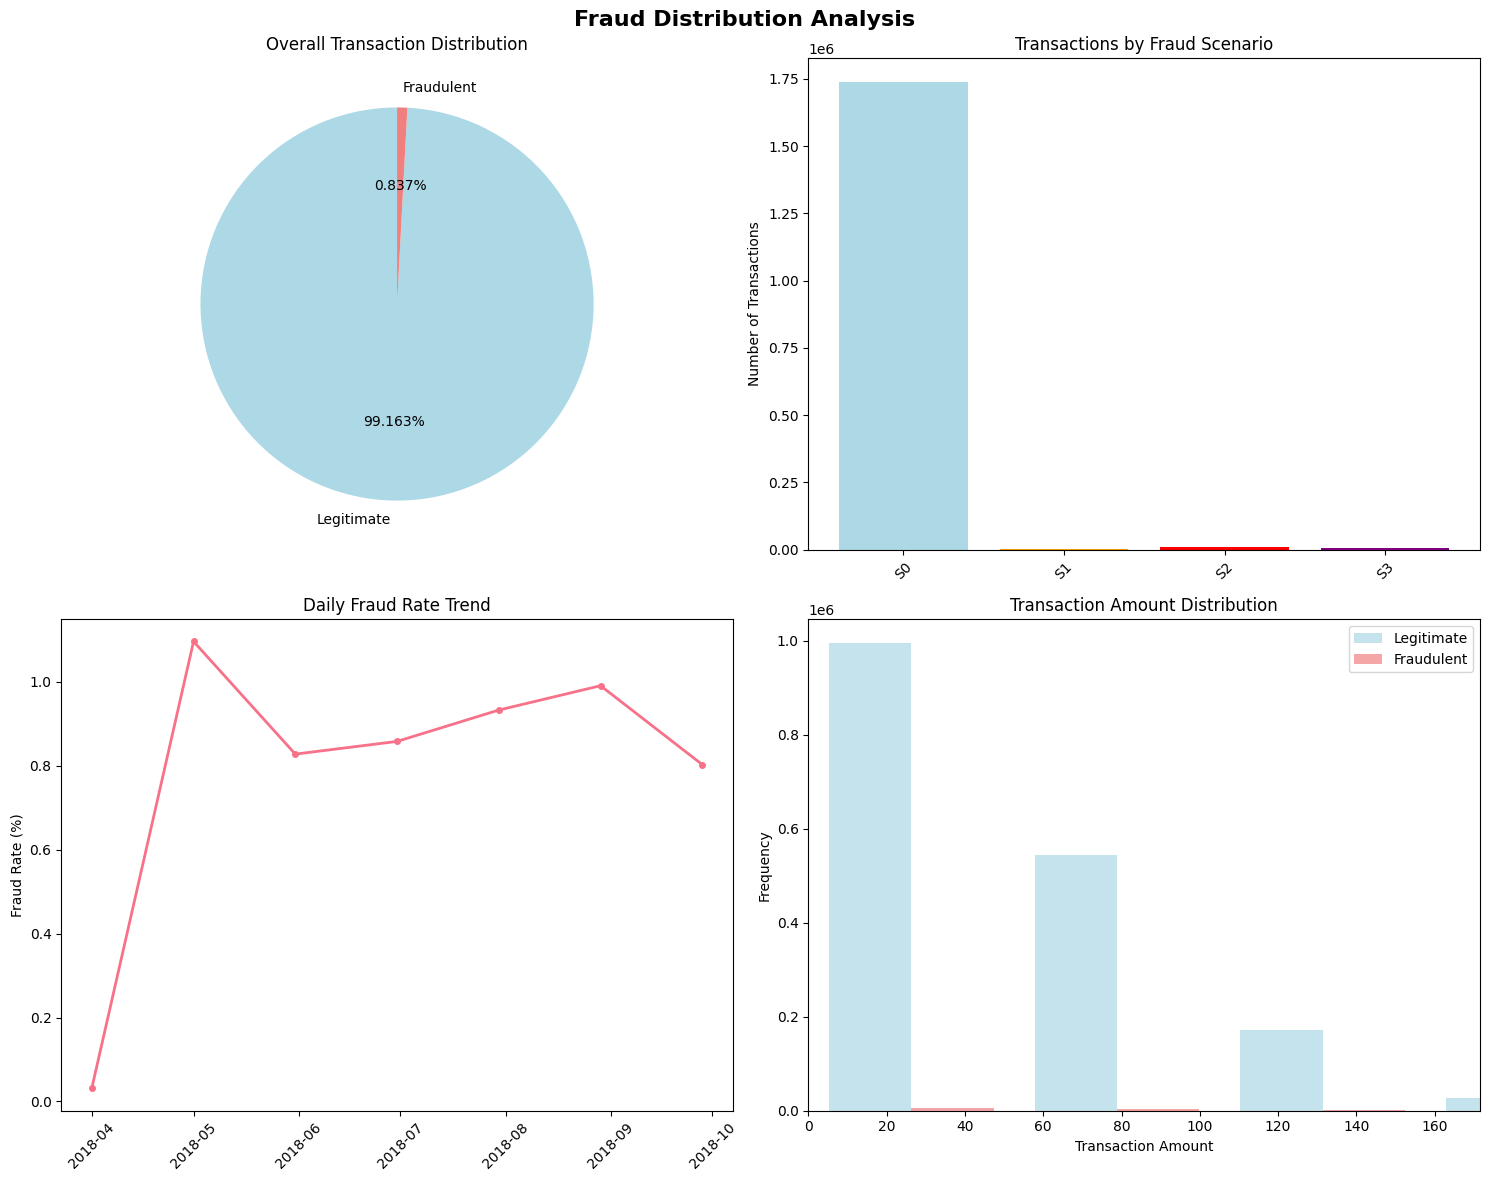

In [4]:
############### statistics ###############
# Overall statistics
fraud_stats = df['TX_FRAUD'].value_counts()
fraud_rate = df['TX_FRAUD'].mean() * 100

print(f"\n1. Overall Fraud Statistics:")
print(f"   - Total transactions: {len(df):,}")
print(f"   - Total legitimate transactions: {fraud_stats[0]:,}")
print(f"   - Overall non-fraud rate: {100-fraud_rate:.3f}%")
print(f"   - Total fraudulent transactions: {fraud_stats[1]:,}")
print(f"   - Overall fraud rate: {fraud_rate:.3f}%")

# scenario
print(f"\n2. Fraud by Scenario:")
scenario_stats = df['TX_FRAUD_SCENARIO'].value_counts().sort_index()
for scenario, count in scenario_stats.items():
    percentage = (count / len(df)) * 100
    if scenario == 0:
        print(f"   - Scenario {scenario} (No fraud): {count:,} ({percentage:.3f}%)")
    else:
        print(f"   - Scenario {scenario} (Fraud type {scenario}): {count:,} ({percentage:.3f}%)")

        
############## visualization #####################

# visulazation section title
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Fraud Distribution Analysis', fontsize=16, fontweight='bold')

# fraud distribution 
axes[0,0].pie(fraud_stats.values, labels=['Legitimate', 'Fraudulent'], 
              autopct='%1.3f%%', startangle=90, colors=['lightblue', 'lightcoral'])
axes[0,0].set_title('Overall Transaction Distribution')

# scenario distribuiton 
scenario_labels = ['No Fraud', 'Scenario 1\n(Amount > 220)', 
                  'Scenario 2\n(Terminal Compromise)', 'Scenario 3\n(Credential Theft)']
axes[0,1].bar(range(len(scenario_stats)), scenario_stats.values, 
              color=['lightblue', 'orange', 'red', 'purple'])
axes[0,1].set_xticks(range(len(scenario_stats)))
axes[0,1].set_xticklabels([f'S{i}' for i in scenario_stats.index], rotation=45)
axes[0,1].set_title('Transactions by Fraud Scenario')
axes[0,1].set_ylabel('Number of Transactions')

# daily trend
df['date'] = df['TX_DATETIME'].dt.date
daily_fraud = df.groupby('date')['TX_FRAUD'].agg(['count', 'sum', 'mean']).reset_index()
daily_fraud['fraud_rate'] = daily_fraud['mean'] * 100

axes[1,0].plot(daily_fraud['date'][::30], daily_fraud['fraud_rate'][::30], 
               marker='o', linewidth=2, markersize=4)
axes[1,0].set_title('Daily Fraud Rate Trend')
axes[1,0].set_ylabel('Fraud Rate (%)')
axes[1,0].tick_params(axis='x', rotation=45)

# fraud amout distributio
fraud_amounts = df[df['TX_FRAUD'] == 1]['TX_AMOUNT']
legit_amounts = df[df['TX_FRAUD'] == 0]['TX_AMOUNT']

axes[1,1].hist([legit_amounts, fraud_amounts], bins=50, alpha=0.7, 
               label=['Legitimate', 'Fraudulent'], color=['lightblue', 'lightcoral'])
axes[1,1].set_title('Transaction Amount Distribution')
axes[1,1].set_xlabel('Transaction Amount')
axes[1,1].set_ylabel('Frequency')
axes[1,1].legend()
axes[1,1].set_xlim(0, df['TX_AMOUNT'].quantile(0.99))

plt.tight_layout()
plt.show()


## 3.3. Temporal Pattern Analysis


1. Hourly Transaction Patterns:
Top 5 hours with highest fraud rates:
      total_txns  fraud_rate
hour                        
1          21861      0.0098
0          15137      0.0094
22         21873      0.0091
4          52403      0.0088
7          94030      0.0086

2. Day of Week Patterns:
           total_txns  fraud_txns  fraud_rate
day_name                                     
Monday         249707        2121      0.0085
Tuesday        248971        2066      0.0083
Wednesday      248716        2112      0.0085
Thursday       249579        2166      0.0087
Friday         248797        2069      0.0083
Saturday       248884        2101      0.0084
Sunday         259501        2046      0.0079

3. Weekend vs Weekday Analysis:
         total_txns  fraud_txns  fraud_rate  avg_amount
Weekday     1245770       10534      0.0085     53.6327
Weekend      508385        4147      0.0082     53.6313


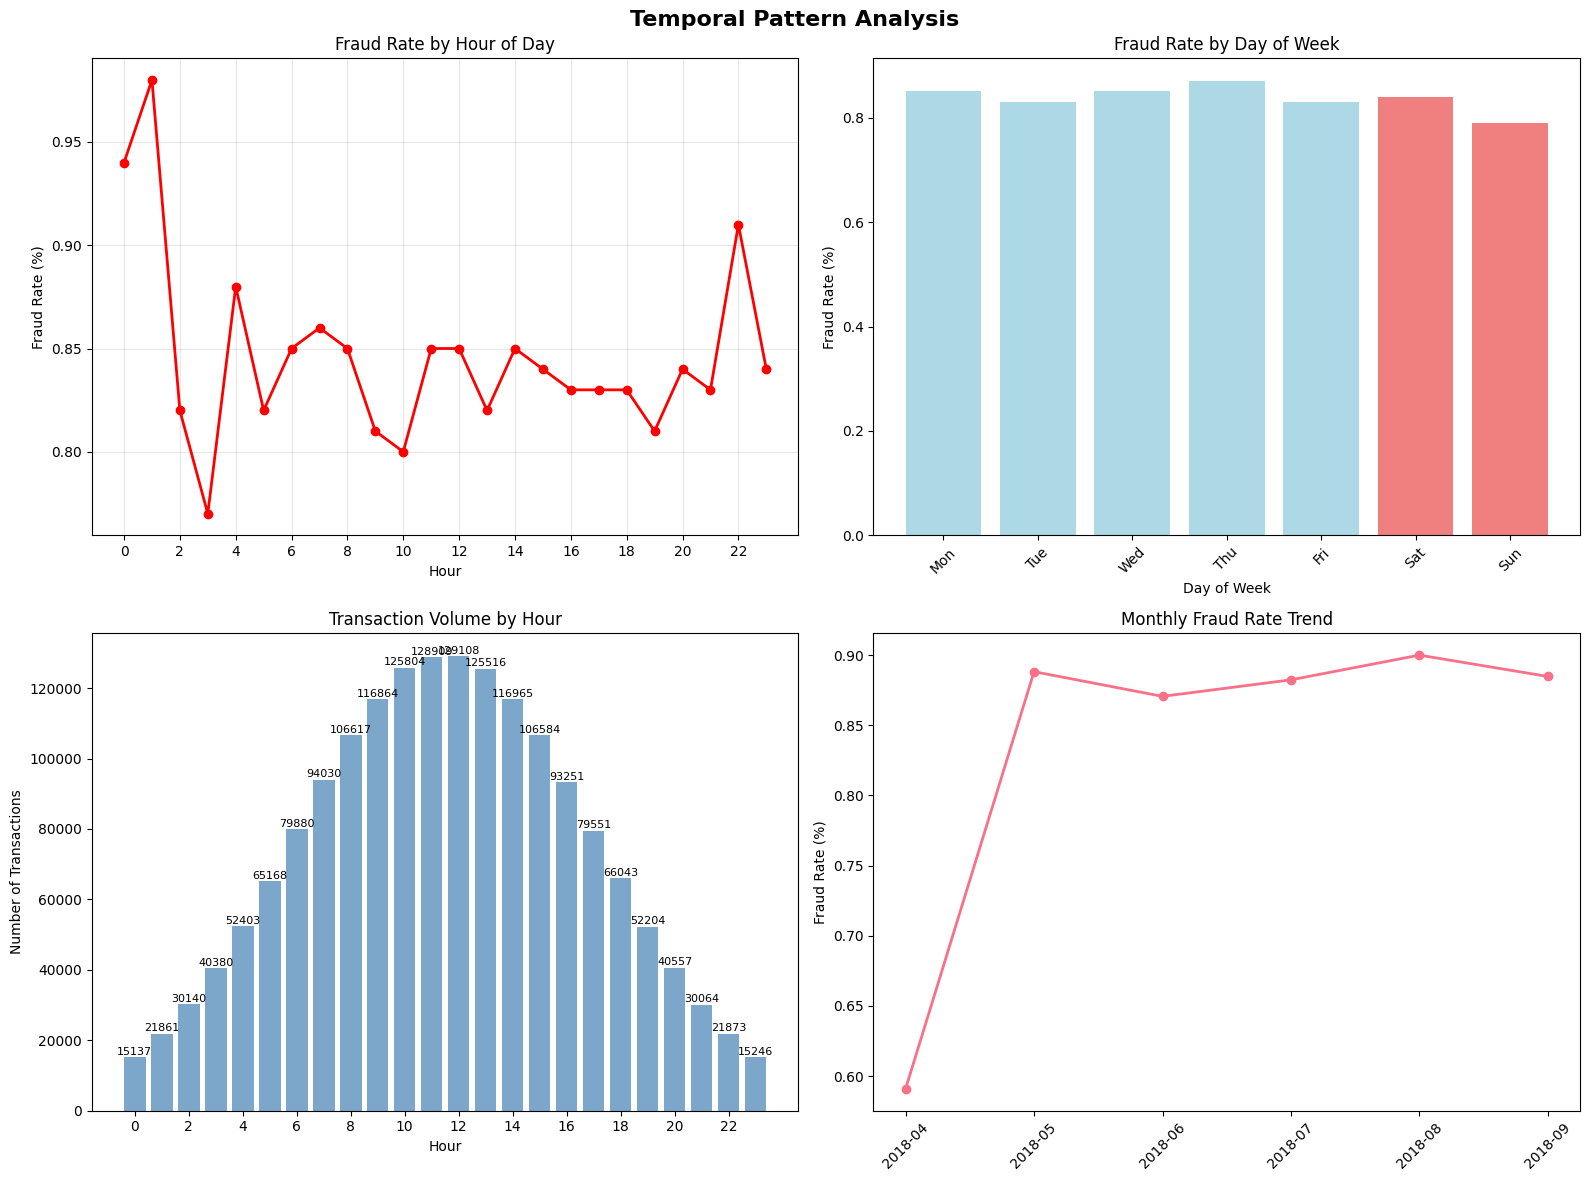

In [5]:
############# calculations ############

# datetime
df['TX_DATETIME'] = pd.to_datetime(df['TX_DATETIME'])
df['hour'] = df['TX_DATETIME'].dt.hour
df['day_of_week'] = df['TX_DATETIME'].dt.dayofweek
df['day_name'] = df['TX_DATETIME'].dt.day_name()
df['is_weekend'] = df['day_of_week'].isin([5, 6])

# hourly patterns
print("\n1. Hourly Transaction Patterns:")
hourly_stats = df.groupby('hour').agg({
    'TX_FRAUD': ['count', 'sum', 'mean']
}).round(4)
hourly_stats.columns = ['total_txns', 'fraud_txns', 'fraud_rate']
print("Top 5 hours with highest fraud rates:")
print(hourly_stats.nlargest(5, 'fraud_rate')[['total_txns', 'fraud_rate']])

# day of week patterns
print("\n2. Day of Week Patterns:")
daily_stats = df.groupby('day_name').agg({
    'TX_FRAUD': ['count', 'sum', 'mean']
}).round(4)
daily_stats.columns = ['total_txns', 'fraud_txns', 'fraud_rate']
daily_stats = daily_stats.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 
                                  'Friday', 'Saturday', 'Sunday'])
print(daily_stats)

# weekend vs weekday analysis
weekend_stats = df.groupby('is_weekend').agg({
    'TX_FRAUD': ['count', 'sum', 'mean'],
    'TX_AMOUNT': 'mean'
}).round(4)
weekend_stats.columns = ['total_txns', 'fraud_txns', 'fraud_rate', 'avg_amount']
weekend_stats.index = ['Weekday', 'Weekend']
print(f"\n3. Weekend vs Weekday Analysis:")
print(weekend_stats)

########## creating visuals ######################
# visulazation section title
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Temporal Pattern Analysis', fontsize=16, fontweight='bold')

# per hour fraud rate
axes[0,0].plot(hourly_stats.index, hourly_stats['fraud_rate'] * 100, 
               marker='o', linewidth=2, markersize=6, color='red')
axes[0,0].set_title('Fraud Rate by Hour of Day')
axes[0,0].set_xlabel('Hour')
axes[0,0].set_ylabel('Fraud Rate (%)')
axes[0,0].grid(True, alpha=0.3)
axes[0,0].set_xticks(range(0, 24, 2))

# per day of week fraud rate
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_reordered = daily_stats.reindex(day_order)
axes[0,1].bar(range(len(day_order)), daily_reordered['fraud_rate'] * 100, 
              color=['lightblue' if day not in ['Saturday', 'Sunday'] else 'lightcoral' 
                     for day in day_order])
axes[0,1].set_title('Fraud Rate by Day of Week')
axes[0,1].set_xlabel('Day of Week')
axes[0,1].set_ylabel('Fraud Rate (%)')
axes[0,1].set_xticks(range(len(day_order)))
axes[0,1].set_xticklabels([day[:3] for day in day_order], rotation=45)

# per hour analysis
hourly_volume = df.groupby('hour').size()
axes[1,0].bar(hourly_volume.index, hourly_volume.values, alpha=0.7, color='steelblue')
axes[1,0].set_title('Transaction Volume by Hour')
axes[1,0].set_xlabel('Hour')
axes[1,0].set_ylabel('Number of Transactions')
axes[1,0].set_xticks(range(0, 24, 2))

#adding number of transactions
for idx, value in zip(hourly_volume.index, hourly_volume.values):
    axes[1,0].text(idx, value + 100, str(value), ha='center', va='bottom', fontsize=8)

# monthly trend (over the 6 month span)

monthly_stats = df.groupby(df['TX_DATETIME'].dt.to_period('M')).agg({
    'TX_FRAUD': ['count', 'sum', 'mean']
})
monthly_stats.columns = ['total_txns', 'fraud_txns', 'fraud_rate']
axes[1,1].plot(monthly_stats.index.astype(str), monthly_stats['fraud_rate'] * 100, 
               marker='o', linewidth=2, markersize=6)
axes[1,1].set_title('Monthly Fraud Rate Trend')
axes[1,1].set_ylabel('Fraud Rate (%)')
axes[1,1].tick_params(axis='x', rotation=45)


plt.tight_layout()
plt.show()

## 3.4. Transaction Amounts Analysis


1. Transaction Amount Statistics:
              count        mean         std   min    25%    50%     75%  \
TX_FRAUD                                                                  
0         1739474.0   52.977907   39.421733  0.00  20.94  44.49   76.63   
1           14681.0  131.168024  154.485795  0.02  32.98  72.22  177.30   

              max  
TX_FRAUD           
0          219.98  
1         2628.00  

2. Amount-based Insights:
   - Average legitimate transaction: $52.98
   - Average fraudulent transaction: $131.17
   - Transactions > $220: 3,258
   - Fraud rate for amounts > $220: 100.00%

3. Fraud Rate by Amount Range:
            total_txns  fraud_txns  fraud_rate
amount_bin                                    
$0-50           962427        5424      0.0056
$50-100         553993        3599      0.0065
$100-220        234476        2399      0.0102
$220-500          2653        2653      1.0000
$500-1000          596         596      1.0000
$1000+              10         

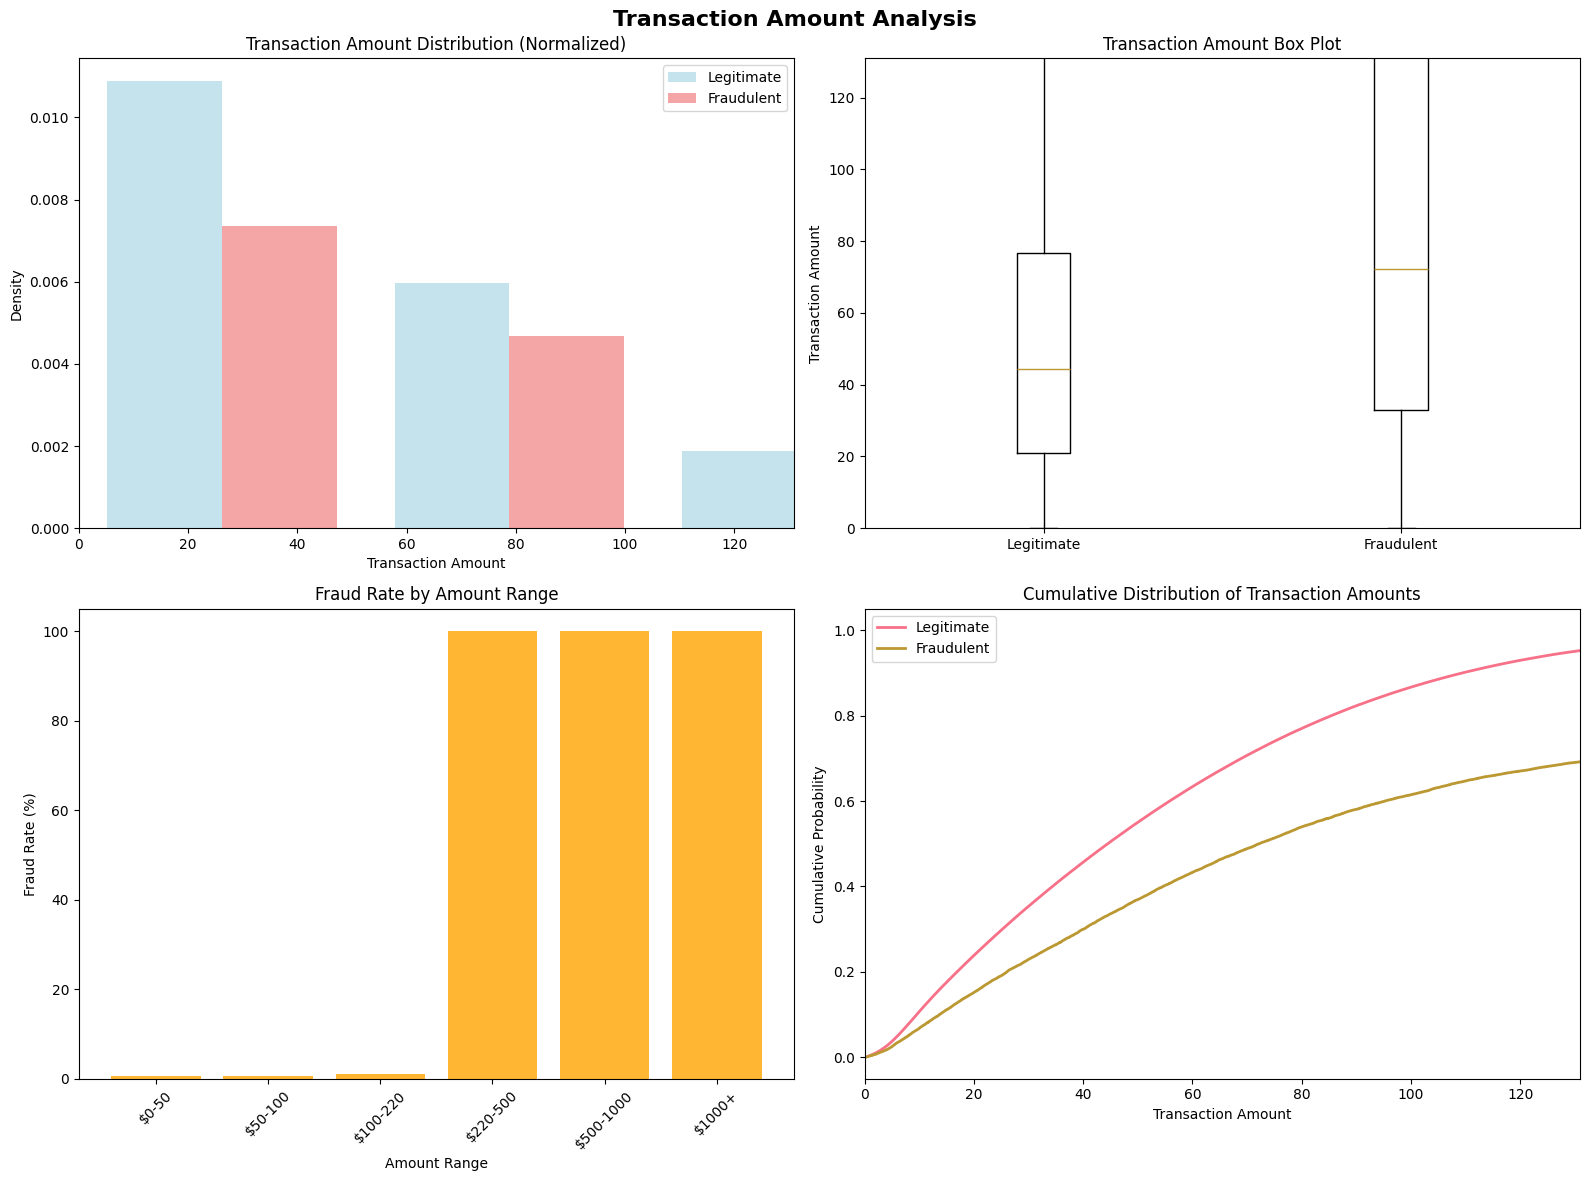

In [6]:
############### statistics ###############
print("\n1. Transaction Amount Statistics:")
amount_stats = df.groupby('TX_FRAUD')['TX_AMOUNT'].describe()
print(amount_stats)

print(f"\n2. Amount-based Insights:")
print(f"   - Average legitimate transaction: ${df[df['TX_FRAUD']==0]['TX_AMOUNT'].mean():.2f}")
print(f"   - Average fraudulent transaction: ${df[df['TX_FRAUD']==1]['TX_AMOUNT'].mean():.2f}")
print(f"   - Transactions > $220: {(df['TX_AMOUNT'] > 220).sum():,}")
print(f"   - Fraud rate for amounts > $220: {df[df['TX_AMOUNT'] > 220]['TX_FRAUD'].mean()*100:.2f}%")

# Amount bins analysis
amount_bins = [0, 50, 100, 220, 500, 1000, float('inf')]
amount_labels = ['$0-50', '$50-100', '$100-220', '$220-500', '$500-1000', '$1000+']
df['amount_bin'] = pd.cut(df['TX_AMOUNT'], bins=amount_bins, labels=amount_labels, right=False)

bin_analysis = df.groupby('amount_bin').agg({
    'TX_FRAUD': ['count', 'sum', 'mean']
}).round(4)
bin_analysis.columns = ['total_txns', 'fraud_txns', 'fraud_rate']

print(f"\n3. Fraud Rate by Amount Range:")
print(bin_analysis)

############## visualization #####################

# visulazation section title
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Transaction Amount Analysis', fontsize=16, fontweight='bold')

# amount distribution analysis
axes[0,0].hist([legit_amounts, fraud_amounts], bins=50, alpha=0.7, 
               label=['Legitimate', 'Fraudulent'], color=['lightblue', 'lightcoral'], density=True)
axes[0,0].set_title('Transaction Amount Distribution (Normalized)')
axes[0,0].set_xlabel('Transaction Amount')
axes[0,0].set_ylabel('Density')
axes[0,0].legend()
axes[0,0].set_xlim(0, df['TX_AMOUNT'].quantile(0.95))

# box plot comparison
fraud_box_data = [df[df['TX_FRAUD']==0]['TX_AMOUNT'], df[df['TX_FRAUD']==1]['TX_AMOUNT']]
axes[0,1].boxplot(fraud_box_data, labels=['Legitimate', 'Fraudulent'])
axes[0,1].set_title('Transaction Amount Box Plot')
axes[0,1].set_ylabel('Transaction Amount')
axes[0,1].set_ylim(0, df['TX_AMOUNT'].quantile(0.95))

# fraud rate amount bins
axes[1,0].bar(range(len(bin_analysis)), bin_analysis['fraud_rate'] * 100, 
              color='orange', alpha=0.8)
axes[1,0].set_title('Fraud Rate by Amount Range')
axes[1,0].set_xlabel('Amount Range')
axes[1,0].set_ylabel('Fraud Rate (%)')
axes[1,0].set_xticks(range(len(amount_labels)))
axes[1,0].set_xticklabels(amount_labels, rotation=45)

# cummulitavie distribution of amounts 
legit_sorted = np.sort(legit_amounts)
fraud_sorted = np.sort(fraud_amounts)
legit_cum = np.arange(1, len(legit_sorted) + 1) / len(legit_sorted)
fraud_cum = np.arange(1, len(fraud_sorted) + 1) / len(fraud_sorted)

axes[1,1].plot(legit_sorted, legit_cum, label='Legitimate', linewidth=2)
axes[1,1].plot(fraud_sorted, fraud_cum, label='Fraudulent', linewidth=2)
axes[1,1].set_title('Cumulative Distribution of Transaction Amounts')
axes[1,1].set_xlabel('Transaction Amount')
axes[1,1].set_ylabel('Cumulative Probability')
axes[1,1].legend()
axes[1,1].set_xlim(0, df['TX_AMOUNT'].quantile(0.95))

plt.tight_layout()
plt.show()

## 3.5. feature correlation analysis

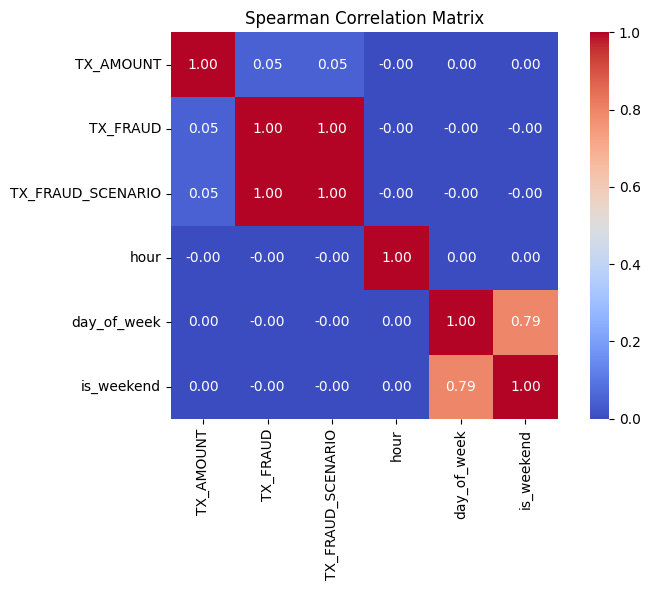


Correlation with TX_FRAUD:
TX_FRAUD_SCENARIO    0.999991
TX_AMOUNT            0.049109
is_weekend          -0.001487
day_of_week         -0.001386
hour                -0.000398
Name: TX_FRAUD, dtype: float64

Features with abs(correlation) > 0.1 with TX_FRAUD:
TX_FRAUD_SCENARIO    0.999991
Name: TX_FRAUD, dtype: float64

Variance Inflation Factors:
             feature        VIF
0              const  10.053035
2  TX_FRAUD_SCENARIO   1.039533
1          TX_AMOUNT   1.039532
4        day_of_week   1.000002
3               hour   1.000001


In [7]:
drop_cols = [
    'TX_DATETIME', 'TRANSACTION_ID', 'CUSTOMER_ID', 'TERMINAL_ID',
    'TX_TIME_SECONDS', 'TX_TIME_DAYS', 'TX_HOUR', 'TX_DAY_OF_WEEK', 'TX_DAY_OF_MONTH',
    'NUM_TRANSACTIONS_LAST_1D', 'AVG_AMOUNT_LAST_1D'
]
df_corr = df.drop(columns=drop_cols, errors='ignore')

# correlation matrix
corr_matrix = df_corr.corr(method='spearman')

# heatmap of correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Spearman Correlation Matrix")
plt.tight_layout()
plt.show()

# correlation with target variable TX_FRAUD
target_corr = corr_matrix['TX_FRAUD'].drop('TX_FRAUD').sort_values(key=abs, ascending=False)
print("\nCorrelation with TX_FRAUD:")
print(target_corr)


threshold = 0.1
print(f"\nFeatures with abs(correlation) > {threshold} with TX_FRAUD:")
print(target_corr[abs(target_corr) > threshold])

# calculate VIF
X = df_corr.drop(columns=['TX_FRAUD'], errors='ignore')
X = X.select_dtypes(include=['float64', 'int64'])
X = X.replace([float('inf'), float('-inf')], pd.NA)
X = X.dropna()
X = add_constant(X)

vif_df = pd.DataFrame()
vif_df["feature"] = X.columns
vif_df["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print("\nVariance Inflation Factors:")
print(vif_df.sort_values(by='VIF', ascending=False))



TX_FRAUD_SCENARIO    1.173005e+01
TX_FRAUD             1.079321e+01
TX_AMOUNT            2.443891e+00
CUSTOMER_ID          1.930939e-03
TX_TIME_DAYS         9.784958e-04
TX_TIME_SECONDS      9.722283e-04
hour                 8.289041e-04
TERMINAL_ID          3.857666e-04
TRANSACTION_ID       5.942134e-15
day_of_week         -6.366760e-03
dtype: float64

Highly skewed features:
TX_FRAUD_SCENARIO    11.730047
TX_FRAUD             10.793208
TX_AMOUNT             2.443891
dtype: float64
0 TX_FRAUD_SCENARIO
1 TX_FRAUD
2 TX_AMOUNT


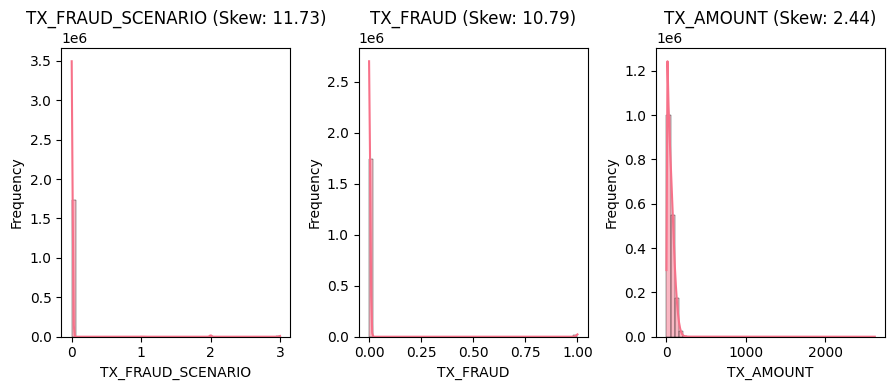

In [8]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
skewness = df[numeric_cols].skew().sort_values(ascending=False)
print(skewness)
# Usually |skewness| > 1 is considered highly skewed
high_skew = skewness[abs(skewness) > 1]
print("\nHighly skewed features:")
print(high_skew)

cols = 5
rows = math.ceil(high_skew.count()/cols)



fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(15, 4))
axes = axes.flatten()  # Make it easier to loop

# Plot each feature in its subplot

for i, col in enumerate(high_skew.index):
    print(i, col)
    sns.histplot(df[col], bins=50, kde=True, ax=axes[i])
    axes[i].set_title(f"{col} (Skew: {skewness[col]:.2f})")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Frequency")

# Remove empty subplots if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


Outliers in TX_AMOUNT: 27449


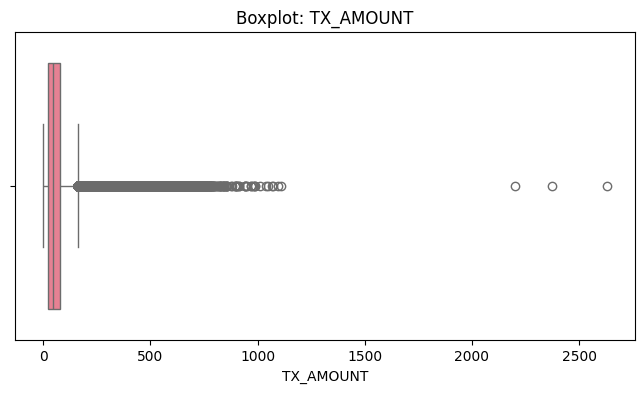

In [12]:
def detect_outliers_iqr(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    return outliers

outliers_tx_amount = detect_outliers_iqr(df, 'TX_AMOUNT')
print(f"Outliers in TX_AMOUNT: {len(outliers_tx_amount)}")

# Multiple features
cols = ['TX_AMOUNT']
for col in cols:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot: {col}')
    plt.show()

## EDA Summary and Key Insights

In [20]:
print(f"""
KEY FINDINGS FROM EDA:

1. DATASET OVERVIEW:
   - Total transactions analyzed: {len(df):,}
   - Fraud rate: {fraud_rate:.3f}% (highly imbalanced)
   - Time period: {df['TX_DATETIME'].min().strftime('%Y-%m-%d')} to {df['TX_DATETIME'].max().strftime('%Y-%m-%d')}
   - Unique customers: {df['CUSTOMER_ID'].nunique():,}
   - Unique terminals: {df['TERMINAL_ID'].nunique():,}

2. FRAUD PATTERNS:
   - Scenario 1 (Amount >$220): {(df['TX_FRAUD_SCENARIO']==1).sum():,} cases
   - Scenario 2 (Terminal compromise): {(df['TX_FRAUD_SCENARIO']==2).sum():,} cases  
   - Scenario 3 (Credential theft): {(df['TX_FRAUD_SCENARIO']==3).sum():,} cases

3. TEMPORAL INSIGHTS:
   - Peak fraud hour: {hourly_stats['fraud_rate'].idxmax()}:00 ({hourly_stats['fraud_rate'].max()*100:.3f}% fraud rate)
   - Weekend fraud rate: {df[df['is_weekend']==True]['TX_FRAUD'].mean()*100:.3f}%
   - Weekday fraud rate: {df[df['is_weekend']==False]['TX_FRAUD'].mean()*100:.3f}%

4. AMOUNT INSIGHTS:
   - Average legitimate transaction: ${df[df['TX_FRAUD']==0]['TX_AMOUNT'].mean():.2f}
   - Average fraudulent transaction: ${df[df['TX_FRAUD']==1]['TX_AMOUNT'].mean():.2f}
   - Highest fraud rate in: {bin_analysis['fraud_rate'].idxmax()} range ({bin_analysis['fraud_rate'].max()*100:.2f}%)

5. DATA QUALITY:
   - Missing values: {df.isnull().sum().sum()}
   - Duplicate records: {df.duplicated().sum()}
   - Data consistency: {'good' if df.isnull().sum().sum() == 0 else 'issues found'}
   
6. CORRELATION PATTERNS with TX_FRAUD:")
  - Highly correlated feature with TX_FRAUD (|correlation| > 0.8):")
{target_corr}
""")




KEY FINDINGS FROM EDA:

1. DATASET OVERVIEW:
   - Total transactions analyzed: 1,754,155
   - Fraud rate: 0.837% (highly imbalanced)
   - Time period: 2018-04-01 to 2018-09-30
   - Unique customers: 4,990
   - Unique terminals: 10,000

2. FRAUD PATTERNS:
   - Scenario 1 (Amount >$220): 973 cases
   - Scenario 2 (Terminal compromise): 9,077 cases  
   - Scenario 3 (Credential theft): 4,631 cases

3. TEMPORAL INSIGHTS:
   - Peak fraud hour: 1:00 (0.980% fraud rate)
   - Weekend fraud rate: 0.816%
   - Weekday fraud rate: 0.846%

4. AMOUNT INSIGHTS:
   - Average legitimate transaction: $52.98
   - Average fraudulent transaction: $131.17
   - Highest fraud rate in: $220-500 range (100.00%)

5. DATA QUALITY:
   - Missing values: 0
   - Duplicate records: 0
   - Data consistency: good
   
6. CORRELATION PATTERNS with TX_FRAUD:")
  - Highly correlated feature with TX_FRAUD (|correlation| > 0.8):")
TX_FRAUD_SCENARIO    0.999991
TX_AMOUNT            0.049109
is_weekend          -0.001487
day_o